## Accessing GOES-R Lightning Detection Data

The Geostationary Lightning Mapper (GLM) is a single-channel, near-infrared optical transient detector that can detect the momentary changes in an optical scene, indicating the presence of lightning.

The GLM data product consists of a hierarchy of earth-located lightning radiant energy measures including events, groups, and flashes:

* Lightning events are detected by the instrument.
* Lightning groups are a collection of one or more lightning events that satisfy temporal and spatial coincidence thresholds.
* Similarly, lightning flashes are a collection of one or more lightning groups that satisfy temporal and spatial coincidence thresholds.

The product includes the relationship among lightning events, groups, and flashes, and the area coverage of lightning groups and flashes. The product also includes processing and data quality metadata, and satellite state and location information.

For more details, see the [GOES-GLM catalog page](http://planetarycomputer.microsoft.com/dataset/goes-glm) and linked documents.

### Data access

The datasets hosted by the Planetary Computer are available from [Azure Blob Storage](https://docs.microsoft.com/en-us/azure/storage/blobs/). We'll use [pystac-client](https://pystac-client.readthedocs.io/) to search the Planetary Computer's [STAC API](https://planetarycomputer.microsoft.com/api/stac/v1/docs) for the subset of the data that we care about, and then we'll load the data directly from Azure Blob Storage. We'll specify a `modifier` so that we can access the data stored in the Planetary Computer's private Blob Storage Containers. See [Reading from the STAC API](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/) and [Using tokens for data access](https://planetarycomputer.microsoft.com/docs/concepts/sas/) for more.

In [1]:
import pystac_client
import planetary_computer

catalog = pystac_client.Client.open(
    "https://planetarycomputer-staging.microsoft.com/api/stac/v1/",
    modifier=planetary_computer.sign_inplace,
)
search = catalog.search(
    collections=["goes-glm"], datetime="2022-10-26T15:00:00/2022-10-26T16:00:00Z"
)
items = search.item_collection()
len(items)

362

Our search for items in the hour from 15:00 - 16:00 matched 362 items. Each item has some useful metadata, including the platform that captured the event:

In [2]:
item = items[0]
item.properties["platform"]

'GOES-17'

And some fields that are unique to GOES

In [3]:
import rich.table

t = rich.table.Table("Property name", "Value")

for k, v in item.properties.items():
    if k.startswith("goes"):
        t.add_row(k, str(v))

t

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Property name                        ┃ Value              ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ goes:event_count                     │ 467                │
│ goes:flash_count                     │ 10                 │
│ goes:group_count                     │ 234                │
│ goes:orbital_slot                    │ West               │
│ goes:yaw_flip_flag                   │ 2                  │
│ goes:system_environment              │ OR                 │
│ goes:flash_time_threshold            │ 3.3299999237060547 │
│ goes:group_time_threshold            │ 0.0                │
│ goes:lightning_wavelength            │ 777.3699951171875  │
│ goes:nominal_satellite_height        │ 35786.0234375      │
│ goes:percent_navigated_L1b_events    │ 1.0                │
│ goes:nominal_satellite_subpoint_lat  │ 0.0                │
│ goes:nominal_satellite_subpoint_lon  │ -137.1999969482422 │
│ goes:percent_uncorrectable_L0_errors │ 0.0                │
└──────────────────────────────────────┴────────────────────┘

Each item has four assets.

In [4]:
import rich.table

t = rich.table.Table("Item key", "Title")
for k, asset in items[0].assets.items():
    t.add_row(k, asset.title)

t

┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Item key           ┃ Title                                 ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ netcdf             │ Original NetCDF4 file                 │
│ geoparquet_events  │ Processed GeoParquet file for events  │
│ geoparquet_groups  │ Processed GeoParquet file for groups  │
│ geoparquet_flashes │ Processed GeoParquet file for flashes │
└────────────────────┴───────────────────────────────────────┘

The NetCDF file is the raw data from NOAA, and includes all the values for events, groups, and flashes. To facilitate cloud-optimized acces, we also provide geoparquet assets for each of these. We recommend using the geoparquet assets.

We'll read in each of the geoparquet tables using [geopandas](https://geopandas.readthedocs.io/).

In [5]:
import geopandas
import fsspec
import pyarrow.fs

fs = pyarrow.fs.PyFileSystem(pyarrow.fs.FSSpecHandler(fsspec.filesystem("http")))

events = geopandas.read_parquet(
    items[0].assets["geoparquet_events"].href, filesystem=fs
)
events.head()

,geometry,id,time,time_offset,energy,parent_group_id
0,POINT (-118.04311 11.86569),102864254,2022-10-26 15:59:41.121539+00:00,1.121539,1.346878e-14,43660952
1,POINT (-118.04311 11.86569),102864255,2022-10-26 15:59:41.123446+00:00,1.123446,9.683006e-15,43660953
2,POINT (-118.04311 11.86569),102864256,2022-10-26 15:59:41.125354+00:00,1.125354,1.607507e-14,43660954
3,POINT (-118.04311 11.86569),102864257,2022-10-26 15:59:41.127643+00:00,1.127643,2.425539e-14,43660955
4,POINT (-118.12436 11.86366),102864258,2022-10-26 15:59:41.127643+00:00,1.127643,1.788046e-15,43660955


In [6]:
groups = geopandas.read_parquet(
    items[0].assets["geoparquet_groups"].href, filesystem=fs
)
groups.head()

,geometry,id,time,time_offset,frame_time,frame_time_offset,area,energy,quality_flag,parent_flash_id
0,POINT (-118.04401 11.86523),43660952,2022-10-26 15:59:41.121539+00:00,1.121539,2022-10-26 15:59:41.243611+00:00,1.243611,72485880.0,1.348357e-14,0,30499
1,POINT (-118.04399 11.86524),43660953,2022-10-26 15:59:41.123446+00:00,1.123446,2022-10-26 15:59:41.245900+00:00,1.245900,72485880.0,9.684022e-15,0,30499
2,POINT (-118.04398 11.86524),43660954,2022-10-26 15:59:41.125354+00:00,1.125354,2022-10-26 15:59:41.247808+00:00,1.247808,72485880.0,1.608325e-14,0,30499
3,POINT (-118.04951 11.86515),43660955,2022-10-26 15:59:41.127643+00:00,1.127643,2022-10-26 15:59:41.249715+00:00,1.249715,144971760.0,2.598206e-14,0,30499
4,POINT (-118.04395 11.86525),43660956,2022-10-26 15:59:41.131457+00:00,1.131457,2022-10-26 15:59:41.253911+00:00,1.253911,72485880.0,2.784850e-15,0,30499


In [7]:
flashes = geopandas.read_parquet(
    items[0].assets["geoparquet_flashes"].href, filesystem=fs
)
flashes.head()

,geometry,id,time_of_first_event,time_offset_of_first_event,time_of_last_event,time_offset_of_last_event,frame_time_of_first_event,frame_time_offset_of_first_event,frame_time_of_last_event,frame_time_offset_of_last_event,area,energy,quality_flag
0,POINT (-118.07206 11.83880),30499,2022-10-26 15:59:41.121539+00:00,1.121539,2022-10-26 15:59:41.405738+00:00,1.405738,2022-10-26 15:59:41.243611+00:00,1.243611,2022-10-26 15:59:41.528192+00:00,1.528192,507401184.0,1.336280e-12,0
1,POINT (-117.87598 11.80840),30500,2022-10-26 15:59:41.374076+00:00,1.374076,2022-10-26 15:59:41.499200+00:00,1.499200,2022-10-26 15:59:41.496148+00:00,1.496148,2022-10-26 15:59:41.621654+00:00,1.621654,290553952.0,4.028499e-14,0
2,POINT (178.37387 12.46468),30503,2022-10-26 15:59:44.899292+00:00,4.899292,2022-10-26 15:59:45.259024+00:00,5.259024,2022-10-26 15:59:45.027086+00:00,5.027086,2022-10-26 15:59:45.386818+00:00,5.386818,255913312.0,2.482841e-13,0
3,POINT (177.27937 22.44949),30502,2022-10-26 15:59:44.001298+00:00,4.001298,2022-10-26 15:59:44.011599+00:00,4.011599,2022-10-26 15:59:44.130619+00:00,4.130619,2022-10-26 15:59:44.140537+00:00,4.140537,161757968.0,7.328486e-14,0
4,POINT (175.18144 21.25999),30504,2022-10-26 15:59:47.640957+00:00,7.640957,2022-10-26 15:59:47.941560+00:00,7.941560,2022-10-26 15:59:47.770658+00:00,7.770658,2022-10-26 15:59:48.070880+00:00,8.070880,720738560.0,3.352838e-13,0


And make a distribution plot of the `energy` variable

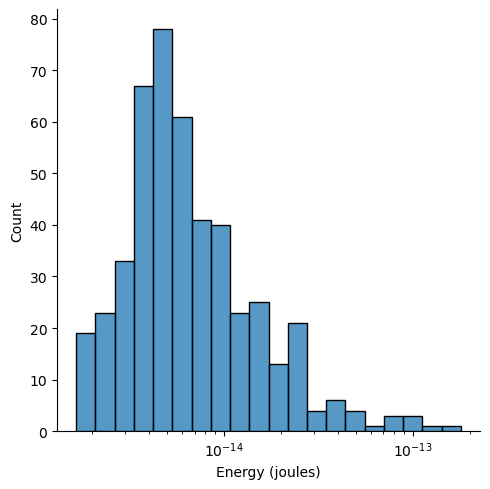

In [8]:
import seaborn as sns

ax = sns.displot(events["energy"], log_scale=True)
ax.set(xlabel="Energy (joules)");

### Reading many items

When working with this many items, just doing operations like reading the metadata of a parquet file for each asset can add up. You might want to parallelize these tasks with some parallel computing framework. In this example, we'll use [Dask](https://dask.org).

In [9]:
import dask_geopandas

In [10]:
%%time
ddf = dask_geopandas.read_parquet(
    [item.assets["geoparquet_events"].href for item in items], filesystem=fs
)

CPU times: user 2.85 s, sys: 316 ms, total: 3.16 s
Wall time: 17.3 s


In [11]:
%%time
energy = ddf["energy"].compute()

CPU times: user 2.68 s, sys: 462 ms, total: 3.15 s
Wall time: 3.51 s


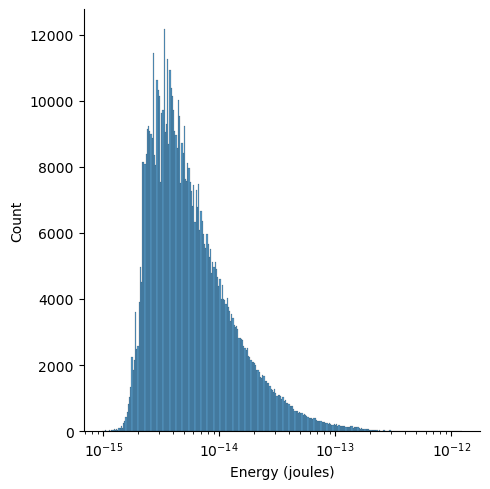

In [12]:
ax = sns.displot(energy, log_scale=True)
ax.set(xlabel="Energy (joules)");